<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">
 
# Decision Trees
 
_Author: Joseph Nelson (DC)_

*Adapted from Chapter 8 of [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/)*

---

## Learning Objectives

Students will be able to:

- Explain how a decision tree is created.
- Build a decision tree model in scikit-learn.
- Tune a decision tree model and explain how tuning impacts the model.
- Interpret a tree diagram.
- Describe the key differences between regression and classification trees.
- Decide whether or not a decision tree is an appropriate model for a given problem.

## Lesson Guide

- [Introduction](#introduction)


- [Part 1: Regression Trees](#part-one)
    - [Group Exercise](#group-exercise)
    - [Building a Regression Tree by Hand](#by-hand)
    - [How Does a Computer build a Regression Tree?](#computer-build)
    - [Demo: Choosing the Ideal Cutpoint for a Given Feature](#cutpoint-demo)
    - [Building a Regression Tree in `scikit-learn`](#sklearn-tree)
    - [What Happens When We Grow a Tree Too Deep?](#too-deep)
    - [Tuning a Regression Tree](#tuning-tree)
    - [Making Predictions for the Testing Data](#testing-preds)


- [Part 2: Classification Trees](#part-two)
    - [Comparing Regression Trees and Classification Trees](#comparing-trees)
    - [Splitting Criteria for Classification Trees](#splitting-criteria)
    - [Building a Classification Tree in `scikit-learn`](#sklearn-ctree)


- [Summary: Comparing Decision Trees With Other Models](#part-three)

<a id="introduction"></a>
## Introduction

In this lesson, we will be exploring **decision trees** and **random forests**. These are non-parametric models that can either be used for regression or classification. 

You are likely very familiar with decision trees already! For example, take this graphic from the New York Times. It explains how to predict whether Barack Obama or Hillary Clinton will win the Democratic primary in a particular county in 2008. At the same time, it informs which features might be most important to predict an Obama or Clinton win:

![Obama-Clinton decision tree](assets/obama_clinton_tree.jpg)

**Random forests** are groups of decision trees created using different subsets and feature sets of the training data. Each tree "votes" on a classification.

### Why are we learning about decision trees?

- They can be applied to both regression and classification problems.
- They are easy to explain to others (interpretable).
- They are very popular among data scientists.
- They are the basis for more sophisticated models.
- They have a different way of "thinking" than the other models we have studied.

<a id="part-one"></a>
# Part 1: Regression Trees

In this section, we will make decision trees that predict numeric data. Instead of returning a class, we will return a single numeric value for each set of conditions.

For example, the following tree predicts Major League Baseball salaries based on Years playing in the major leagues and Hits the previous year. Only three different salaries are ever predicted (the average salaries of players that meet each set of conditions): 

![Salary tree](assets/salary_tree.png)

The salary has been divided by 1,000 and log-normalized, for example a salary of \$166,000 refers to the number:

$$5.11 = \ln(\$166000/1000)$$

Similarly, 6.00 is \$403,000, and 6.74 is \$846,000. A natural log transform was made because some salaries are much higher than others, leading to a non-ideal long-tail distribution.


Our dataset will be Major League Baseball player data from 1986–87:

- **Years** (x-axis): Number of years playing in the major leagues.
- **Hits** (y-axis): Number of hits in the previous year.
- **Salary** (color): Low salary is blue/green, high salary is red/yellow.

![Salary data](assets/salary_color.png)

<a id="group-exercise"></a>
### Group Exercise

- The data set above is our **training data**.
- We want to build a model that predicts the salary of **future players** based on years and hits.
- We are going to "segment" the feature space into regions, and then use the **mean salary in each region** as the predicted Salary for future players.
- Intuitively, you want to **maximize** the similarity (or "homogeneity") within a given region, and **minimize** the similarity between different regions.

#### Rules for Segmenting

- You can only use **straight lines** that are drawn one at a time.
- Your line must either be **vertical or horizontal**.
- Your line **stops** when it hits an existing line.

---

**Solution (only look AFTER the group exercise!):** [Salary regions](assets/salary_regions.png)

As shown in the solution above, the regions created by a computer are:

- $R_1$: Players with **less than 5 years** of experience and a mean salary of **\$166,000**.
- $R_2$: Players with **5 or more years** of experience and **less than 118 hits** and mean salary of **\$403,000**.
- $R_3$: Players with **5 or more years** of experience and **118 hits or more** and mean Salary of **\$846,000**.

**Note:** Years and hits are both integers, but the convention is to use the **midpoint** between adjacent values to label a split.

These regions are used to make predictions for **out-of-sample data**. Thus, there are only three possible predictions! (Is this different from how **linear regression** makes predictions?)

Below is the equivalent regression tree:

![Salary tree](assets/salary_tree.png)

The first split is **years < 4.5**, thus that split goes at the top of the tree. When a splitting rule is **true**, you follow the left branch. When a splitting rule is **false**, you follow the right branch.

For players in the **left branch**, the mean salary is \$166,000, thus you label it with that value. (Salary has been divided by 1,000 and log-transformed to 5.11.)

For players in the **right branch**, there is a further split on **hits < 117.5**, dividing players into two more salary regions: \$403,000 (transformed to 6.00), and \$846,000 (transformed to 6.74).

![Salary tree annotated](assets/salary_tree_annotated.png)

**What does this tree tell you about your data?**

- Years is the most important factor determining salary, with a lower number of years corresponding to a lower salary.
- For a player with a lower number of years, hits is not an important factor in determining salary.
- For a player with a higher number of years, hits is an important factor in determining salary, with a greater number of hits corresponding to a higher salary.

**Question:** What do you like and dislike about decision trees so far?

<a id="by-hand"></a>
## Building a Regression Tree by Hand

Your **training data** is a tiny data set of [used vehicle sale prices](./data/vehicles_train.csv). Your goal is to **predict price** for testing data.

1. Read the data into a Pandas DataFrame.
2. Explore the data by sorting, plotting, or performing split-apply-combine (a.k.a. `group_by`).
3. Decide which feature is the most important predictor, and use that to create your first splitting rule.
    - Only binary splits are allowed.
4. After making your first split, split your DataFrame into two parts and then explore each part to figure out what other splits to make.
5. Stop making splits once you are convinced that it strikes a good balance between underfitting and overfitting.
    - Your goal is to build a model that generalizes well.
    - You are allowed to split on the same variable multiple times.
6. Draw your tree, labeling the leaves with the mean price for the observations in that region.
    - Make sure nothing is backwards: You follow the **left branch** if the rule is true and the **right branch** if the rule is false.

<a id="computer-build"></a>
## How Does a Computer Build a Regression Tree?

**Ideal approach:** Considering every possible partition of the feature space (computationally infeasible).

**"Good enough" approach:** Recursive binary splitting.

1. Begin at the top of the tree.
2. For **every feature**, examine **every possible cutpoint**, and choose the feature and cutpoint so that the resulting tree has the lowest possible mean squared error (MSE). Make that split.
3. Examine the two resulting regions. Once again, make a **single split** (in one of the regions) to minimize the MSE.
4. Keep repeating Step 3 until a **stopping criterion** is met:
    - Maximum tree depth (maximum number of splits required to arrive at a leaf).
    - Minimum number of observations in a leaf.

---

This is a **greedy algorithm** because it makes locally optimal decisions -- it takes the best split at each step. A greedy algorithm hopes that a series of locally optimal decisions might be optimal overall; however, this is not always the case. For example:

- Always eating cookies to maximize your immediate happiness (greedy) might not lead to optimal overall happiness.

- In our case, reorganizing parts of the tree already constructed based on future splits might result in a better model overall. 

<a id="cutpoint-demo"></a>
### Demo: Choosing the Ideal Cutpoint for a Given Feature

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# allow plots to appear in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['font.size'] = 14

# Vehicle data
path = './data/vehicles_train.csv'
train = pd.read_csv(path)

In [2]:
# Before splitting anything, just predict the mean of the entire data set.
train['prediction'] = train.price.mean()
train

,price,year,miles,doors,vtype,prediction
0,22000,2012,13000,2,car,6571.428571
1,14000,2010,30000,2,car,6571.428571
2,13000,2010,73500,4,car,6571.428571
3,9500,2009,78000,4,car,6571.428571
4,9000,2007,47000,4,car,6571.428571
5,4000,2006,124000,2,car,6571.428571
6,3000,2004,177000,4,car,6571.428571
7,2000,2004,209000,4,truck,6571.428571
8,3000,2003,138000,2,car,6571.428571
9,1900,2003,160000,4,car,6571.428571


In [3]:
# Calculate RMSE for those predictions.
from sklearn import metrics
import numpy as np

np.sqrt(metrics.mean_squared_error(train.price, train.prediction))

5936.981985995983

In [4]:
# Define a function that calculates the RMSE for a given split of miles.
def mileage_split(miles):
    lower_mileage_price = train[train.miles < miles].price.mean()
    higher_mileage_price = train[train.miles >= miles].price.mean()
    train['prediction'] = np.where(train.miles < miles, lower_mileage_price, higher_mileage_price)
    return np.sqrt(metrics.mean_squared_error(train.price, train.prediction))

In [5]:
# Calculate RMSE for tree that splits on miles < 50,000.
print('RMSE:', mileage_split(50000))
train

RMSE: 3984.0917425414564


,price,year,miles,doors,vtype,prediction
0,22000,2012,13000,2,car,15000.000000
1,14000,2010,30000,2,car,15000.000000
2,13000,2010,73500,4,car,4272.727273
3,9500,2009,78000,4,car,4272.727273
4,9000,2007,47000,4,car,15000.000000
5,4000,2006,124000,2,car,4272.727273
6,3000,2004,177000,4,car,4272.727273
7,2000,2004,209000,4,truck,4272.727273
8,3000,2003,138000,2,car,4272.727273
9,1900,2003,160000,4,car,4272.727273


In [6]:
# Calculate RMSE for tree that splits on miles < 100,000.
print('RMSE:', mileage_split(100000))
train

RMSE: 3530.146530076269


,price,year,miles,doors,vtype,prediction
0,22000,2012,13000,2,car,12083.333333
1,14000,2010,30000,2,car,12083.333333
2,13000,2010,73500,4,car,12083.333333
3,9500,2009,78000,4,car,12083.333333
4,9000,2007,47000,4,car,12083.333333
5,4000,2006,124000,2,car,2437.500000
6,3000,2004,177000,4,car,2437.500000
7,2000,2004,209000,4,truck,2437.500000
8,3000,2003,138000,2,car,2437.500000
9,1900,2003,160000,4,car,2437.500000


In [7]:
# Check all possible mileage splits.
mileage_range = list(range(train.miles.min(), train.miles.max(), 1000))
RMSE = [mileage_split(miles) for miles in mileage_range]

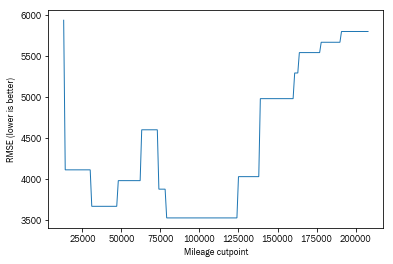

In [8]:
# Plot mileage cutpoint (x-axis) versus RMSE (y-axis).
plt.plot(mileage_range, RMSE);
plt.xlabel('Mileage cutpoint');
plt.ylabel('RMSE (lower is better)');

**Recap:** Before every split, we repeat this process for every feature and choose the feature and cutpoint that produce the lowest MSE.

<a id="sklearn-tree"></a>
## Building a Regression Tree in `scikit-learn`

In [9]:
# Encode car as 0 and truck as 1.
train['vtype'] = train.vtype.map({'car':0, 'truck':1})

In [10]:
# Define X and y.
feature_cols = ['year', 'miles', 'doors', 'vtype']

X = train[feature_cols]
y = train.price

In [11]:
# Instantiate a DecisionTreeRegressor (with random_state=1).
from sklearn.tree import DecisionTreeRegressor

treereg = DecisionTreeRegressor(random_state=1)
treereg

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1, splitter='best')

In [12]:
# Use leave-one-out cross-validation (LOOCV) to estimate the RMSE for this model.
from sklearn.model_selection import cross_val_score
scores = cross_val_score(treereg, X, y, cv=14, scoring='neg_mean_squared_error')
np.mean(np.sqrt(-scores))

3107.1428571428573

<a id="too-deep"></a>
## What Happens When We Grow a Tree Too Deep?

- **On the left:** A regression tree for salary that is **grown deeper**.
- **On the right:** A comparison of the **training, testing, and cross-validation errors** for trees with different numbers of leaves.

![Salary tree grown deep](assets/salary_tree_deep.png)

The **training error** continues to go down as the tree size increases (due to overfitting), but the lowest **cross-validation error** occurs for a tree with three leaves. 

Note that if we make a **complete tree** (where every data point is boxed into its own region), then we will achieve perfect training accuracy. However, then outliers in the training data will greatly affect the model.

<a id="#tuning-tree"></a>
## Tuning a Regression Tree

Let's try to reduce the RMSE by tuning the **max_depth** parameter:

In [13]:
# Try different values one by one.
treereg = DecisionTreeRegressor(max_depth=1, random_state=1)
scores = cross_val_score(treereg, X, y, cv=14, scoring='neg_mean_squared_error')
np.mean(np.sqrt(-scores))

4050.1443001443

Or, we could write a loop to try a range of values:

In [14]:
# List of values to try:
max_depth_range = list(range(1, 8))

# List to store the average RMSE for each value of max_depth:
RMSE_scores = []

# Use LOOCV with each value of max_depth.
for depth in max_depth_range:
    treereg = DecisionTreeRegressor(max_depth=depth, random_state=1)
    MSE_scores = cross_val_score(treereg, X, y, cv=14, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

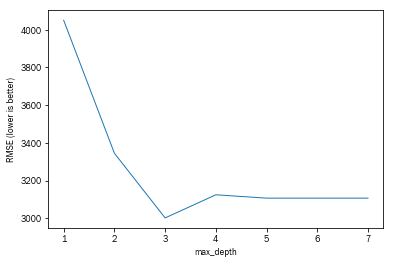

In [15]:
# Plot max_depth (x-axis) versus RMSE (y-axis).
plt.plot(max_depth_range, RMSE_scores);
plt.xlabel('max_depth');
plt.ylabel('RMSE (lower is better)');

In [16]:
# max_depth=3 was best, so fit a tree using that parameter.
treereg = DecisionTreeRegressor(max_depth=3, random_state=1)
treereg.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1, splitter='best')

In [17]:
# "Gini importance" of each feature: the (normalized) total reduction of error brought by that feature.
pd.DataFrame({'feature':feature_cols, 'importance':treereg.feature_importances_})

,feature,importance
0,year,0.798744
1,miles,0.201256
2,doors,0.000000
3,vtype,0.000000


### Creating a Tree Diagram

To create a tree diagram, we will use the Graphviz library for displaying graph data structures. 

Surprisingly, every tree is just a graph in disguise! A graph is a tree only if there is exactly one vertex with no incoming edge (the root), while all other vertices have exactly one incoming edge (representing its parent).

In [18]:
# Create a Graphviz file.
from sklearn.tree import export_graphviz
export_graphviz(treereg, out_file='./assets/tree_vehicles.dot', feature_names=feature_cols)

# At the command line, run this to convert to PNG:
#   dot -Tpng tree_vehicles.dot -o tree_vehicles.png

# Or, you can drag the image below to your desktop or Powerpoint!

![Tree for vehicle data](assets/tree_vehicles.png)

Reading the internal nodes:

- **samples:** Number of observations in that node before splitting.
- **mse:** MSE calculated by comparing the actual response values in that node against the mean response value in that node.
- **rule:** Rule used to split that node (go left if true, go right if false).

Reading the leaves:

- **samples:** Number of observations in that node.
- **value:** Mean response value in that node.
- **mse:** MSE calculated by comparing the actual response values in that node against "value."

<a id="testing-preds"></a>
## Making Predictions for the Testing Data

In [19]:
# Read the testing data.
path = './data/vehicles_test.csv'

test = pd.read_csv(path)
test['vtype'] = test.vtype.map({'car':0, 'truck':1})
test

,price,year,miles,doors,vtype
0,3000,2003,130000,4,1
1,6000,2005,82500,4,0
2,12000,2010,60000,2,0


**Question:** Using the tree diagram above, what predictions will the model make for each observation?

In [20]:
# Use fitted model to make predictions on testing data.
X_test = test[feature_cols]
y_test = test.price
y_pred = treereg.predict(X_test)

y_pred

array([ 4000.,  5000., 13500.])

In [21]:
# Calculate RMSE
np.sqrt(metrics.mean_squared_error(y_test, y_pred))

1190.2380714238084

In [22]:
# Calculate RMSE for your own tree.
y_test = [3000, 6000, 12000]
y_pred = [0, 0, 0]

from sklearn import metrics
np.sqrt(metrics.mean_squared_error(y_test, y_pred))

7937.253933193771

<a id="part-two"></a>
# Part 2: Classification Trees

**Example:** Predict whether or not Barack Obama or Hillary Clinton will win the Democratic primary in a particular county in 2008 (from the New York Times).

![Obama-Clinton decision tree](assets/obama_clinton_tree.jpg)

**Questions:**

- What are the observations? How many observations are there?
- What is the response variable?
- What are the features?
- What is the most predictive feature?
- Why does the tree split on high school graduation rate twice in a row?
- What is the class prediction for the following county: 15 percent African American, 90 percent high school graduation rate, located in the South, high poverty, high population density?
- What is the predicted probability for that same county?

<a id="comparing-trees"></a>
## Comparing Regression Trees and Classification Trees

|Regression Trees|Classification Trees|
|---|---|
|Predict a continuous response.|Predict a categorical response.|
|Predict using mean response of each leaf.|Predict using most commonly occurring class of each leaf.|
|Splits are chosen to minimize MSE.|Splits are chosen to minimize Gini index (discussed below).|

<a id="splitting-criteria"></a>
## Splitting Criteria for Classification Trees

Common options for the splitting criteria:

- **Classification error rate:** The fraction of training observations in a region that don't belong to the most common class.
- **Gini index:** The measure of total variance across classes in a region.

### Example: Classification Error Rate

Pretend we are predicting whether or not someone will buy an iPhone or an Android:

- At a particular node, there are **25 observations** (phone buyers) of whom **10 bought iPhones and 15 bought Androids**.
- As the majority class is **Android**, that's our prediction for all 25 observations, and thus the classification error rate is **10/25 = 40%**.

Our goal in making splits is to **reduce the classification error rate**. Let's try splitting on gender:

- **Males:** Two iPhones and 12 Androids, thus the predicted class is Android.
- **Females:** Eight iPhones and three Androids, thus the predicted class is iPhone.
- Classification error rate after this split would be **5/25 = 20%**.

Compare that with a split on age:

- **30 or younger:** Four iPhones and eight Androids, thus the predicted class is Android.
- **31 or older:** Six iPhones and seven Androids, thus the predicted class is Android.
- Classification error rate after this split would be **10/25 = 40%**.

The decision tree algorithm will try **every possible split across all features** and choose the one that **reduces the error rate the most.**

### Example: Gini Index

Calculate the Gini index before making a split:

$$1 - \left(\frac {iPhone} {Total}\right)^2 - \left(\frac {Android} {Total}\right)^2 = 1 - \left(\frac {10} {25}\right)^2 - \left(\frac {15} {25}\right)^2 = 0.48$$

- The **maximum value** of the Gini index is 0.5 and occurs when the classes are perfectly balanced in a node.
- The **minimum value** of the Gini index is 0 and occurs when there is only one class represented in a node.
- A node with a lower Gini index is said to be more "pure."

Evaluating the split on **gender** using the Gini index:

$$\text{Males: } 1 - \left(\frac {2} {14}\right)^2 - \left(\frac {12} {14}\right)^2 = 0.24$$
$$\text{Females: } 1 - \left(\frac {8} {11}\right)^2 - \left(\frac {3} {11}\right)^2 = 0.40$$
$$\text{Weighted Average: } 0.24 \left(\frac {14} {25}\right) + 0.40 \left(\frac {11} {25}\right) = 0.31$$

Evaluating the split on **age** using the Gini index:

$$\text{30 or younger: } 1 - \left(\frac {4} {12}\right)^2 - \left(\frac {8} {12}\right)^2 = 0.44$$
$$\text{31 or older: } 1 - \left(\frac {6} {13}\right)^2 - \left(\frac {7} {13}\right)^2 = 0.50$$
$$\text{Weighted Average: } 0.44 \left(\frac {12} {25}\right) + 0.50 \left(\frac {13} {25}\right) = 0.47$$

Again, the decision tree algorithm will try **every possible split** and will choose the one that **reduces the Gini index (and thus increases the "node purity") the most**.

You can think of this as each split increasing the accuracy of predictions. If there is some error at a node, then splitting at that node will result in two nodes with a higher average "node purity" than the original. So, we ensure continually better fits to the training data by continually splitting nodes.

### Comparing Classification Error Rate and Gini Index

- Gini index is generally preferred because it will make splits that **increase node purity**, even if that split does not change the classification error rate.
- Node purity is important because we're interested in the **class proportions** in each region, as that's how we calculate the **predicted probability** of each class.
- scikit-learn's default splitting criteria for classification trees is Gini index.

**Note:** There is another common splitting criteria called **cross-entropy**. It's numerically similar to Gini index but slower to compute. So, it's not as popular as Gini index.

<a id="sklearn-ctree"></a>
## Building a Classification Tree in `scikit-learn`

We'll build a classification tree using the Titanic survival data set:

In [23]:
# Read in the data.
path = './data/titanic.csv'
titanic = pd.read_csv(path)

# Encode female as 0 and male as 1.
titanic['Sex'] = titanic.Sex.map({'female':0, 'male':1})

# Fill in the missing values for age with the median age.
titanic.Age.fillna(titanic.Age.median(), inplace=True)

# Create a DataFrame of dummy variables for Embarked.
embarked_dummies = pd.get_dummies(titanic.Embarked, prefix='Embarked')
embarked_dummies.drop(embarked_dummies.columns[0], axis=1, inplace=True)

# Concatenate the original DataFrame and the dummy DataFrame.
titanic = pd.concat([titanic, embarked_dummies], axis=1)

# Print the updated DataFrame.
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C,0,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S,0,1
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S,0,1


- **Survived:** 0=died, 1=survived (response variable)
- **Pclass:** 1=first class, 2=second class, 3=third class
    - What will happen if the tree splits on this feature?
- **Sex:** 0=female, 1=male
- **Age:** Numeric value
- **Embarked:** C or Q or S

In [24]:
# Define X and y.
feature_cols = ['Pclass', 'Sex', 'Age', 'Embarked_Q', 'Embarked_S']

X = titanic[feature_cols]
y = titanic.Survived

In [25]:
# Fit a classification tree with max_depth=3 on all data.
from sklearn.tree import DecisionTreeClassifier

treeclf = DecisionTreeClassifier(max_depth=3, random_state=1)
treeclf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

In [26]:
# Create a Graphviz file.
export_graphviz(treeclf, out_file='./assets/tree_titanic.dot', feature_names=feature_cols)

# At the command line, run this to convert to PNG:
#   dot -Tpng tree_titanic.dot -o tree_titanic.png

# Or, just drag this image to your desktop or Powerpoint.

![Tree for Titanic data](assets/tree_titanic.png)

Notice the split in the bottom right; the **same class** is predicted in both of its leaves. That split didn't affect the **classification error rate**, although it did increase the **node purity**. This is important because it increases the accuracy of our predicted probabilities.

A useful side effect of measures such as the Gini index is that they can be used give some indication of feature importance:

In [27]:
# Compute the feature importances (the Gini index at each node).

pd.DataFrame({'feature':feature_cols, 'importance':treeclf.feature_importances_})

,feature,importance
0,Pclass,0.242664
1,Sex,0.655584
2,Age,0.064494
3,Embarked_Q,0.000000
4,Embarked_S,0.037258


<a id="part-three"></a>
# Summary: Comparing Decision Trees With Other Models

**Advantages of decision trees:**

- They can be used for regression or classification.
- They can be displayed graphically.
- They are highly interpretable.
- They can be specified as a series of rules, and more closely approximate human decision-making than other models.
- Prediction is fast.
- Their features don't need scaling.
- They authomatically learn feature interactions.
- Tends to ignore irrelevant features.
- They are non-parametric (i.e. will outperform linear models if the relationship between features and response is highly non-linear).

![Trees versus linear models](assets/tree_vs_linear.png)

**Disadvantages of decision trees:**

- Their performance is (generally) not competitive with the best supervised learning methods.
- They can easily overfit the training data (tuning is required).
- Small variations in the data can result in a completely different tree (high variance).
- Recursive binary splitting makes "locally optimal" decisions that may not result in a globally optimal tree.
- They don't tend to work well if the classes are highly unbalanced.
- They don't tend to work well with very small data sets.